# Train Diffusion Model
### Imports

In [1]:
!pip install librosa
#Set Dir 
import sys, os
sys.path.append(os.path.abspath('..'))
# Torch
import torch
from torch import nn, Tensor
from torch.utils.data import DataLoader
import torch.optim as optim
# Utils
import numpy as np
from numpy import ndarray
import logging

# Base Scripts
from Libraries.U_Net import *
from Libraries.Diffusion import *
from Libraries.Utils import *
from MainScripts.Conf import *

### Conf

In [2]:
remote_kernel: bool = True

device = "cuda" if torch.cuda.is_available() else "cpu"
model_name: str = "diffusion_v3"
training_data_name: str = "training_full_low_res"
model_path: str = path_to_remote_path(f"{MODEL_PATH}/{model_name}.pth", remote_kernel)
logging_level: int = logging.INFO
logging.basicConfig(level=logging_level, format='%(asctime)s - %(levelname)s - %(message)s')
logger: logging.Logger = logging.getLogger(__name__)

In [3]:
diffusion_timesteps: int = 500
n_starting_filters: int = 32
n_downsamples: int = 3
time_embed_dim: int = 128
n_starting_attention_size: int = 32

### Functions

In [ ]:
def bwd_pass(model: Diffusion, n_samples: int = 1, file_name: str = "test") -> None:
    x: ndarray = model.bwd_diffusion(n_samples=n_samples)
    print(x[0,0].shape)
    for i in range(x.shape[0]):
        logger.info(f"Sample {i}")
        visualize_spectogram(x[i, 0])
        audio = spectrogram_to_audio(unnormalize(x[i, 0]), LEN_FFT)
        save_audio_file(audio, path_to_remote_path(f"{RESULT_PATH}/{file_name}_{i:02d}_out.wav", remote_kernel))
    logger.light_debug(f"Saved passed through samples to {RESULT_PATH}")

### Data Loading & Model Creation

In [5]:
file = load_training_data(path_to_remote_path(f"{DATA_PATH}/{training_data_name}.npy", remote_kernel))[:100,...]
logger.info(f"Data loaded with shape: {file.shape}")

u_net = Conv_U_NET(in_channels=1, time_embed_dim=time_embed_dim, n_starting_filters=n_starting_filters, n_downsamples=n_downsamples, activation=nn.GELU(), device=device)
u_net.load_state_dict(torch.load(model_path, weights_only=False, map_location=device))
logger.info(f"Model {model_name} loaded with {count_parameters(u_net)} Parameters")


u_net = u_net.to(device)

model = Diffusion(model=u_net, noise_steps=diffusion_timesteps, noise_schedule="linear", input_dim=[8, 1, file.shape[-2], file.shape[-1]], device=device)


2025-03-07 08:42:20,867 - INFO - Data loaded with shape: (100, 224, 416)
2025-03-07 08:42:25,436 - INFO - Model diffusion_v3 loaded with 17288513 Parameters


### Evaluate

2025-03-07 08:47:53,579 - INFO - Started sampling 8 samples


Step 490:
  alpha_t: 0.980319
  alpha_hat_t: 0.007459
  beta_t: 0.019681
  pred_noise mean/std: 0.001, 0.979
  pred_noise min/max: -4.836, 4.720
  x min/max: -4.863, 4.898
Step 480:
  alpha_t: 0.980718
  alpha_hat_t: 0.009082
  beta_t: 0.019282
  pred_noise mean/std: 0.003, 0.978
  pred_noise min/max: -4.600, 4.475
  x min/max: -4.789, 4.708
Step 470:
  alpha_t: 0.981117
  alpha_hat_t: 0.011014
  beta_t: 0.018883
  pred_noise mean/std: 0.003, 0.977
  pred_noise min/max: -4.234, 4.777
  x min/max: -4.653, 4.709
Step 460:
  alpha_t: 0.981515
  alpha_hat_t: 0.013303
  beta_t: 0.018485
  pred_noise mean/std: 0.004, 0.977
  pred_noise min/max: -4.406, 4.617
  x min/max: -4.739, 4.785
Step 450:
  alpha_t: 0.981914
  alpha_hat_t: 0.016002
  beta_t: 0.018086
  pred_noise mean/std: 0.005, 0.976
  pred_noise min/max: -4.314, 4.707
  x min/max: -5.331, 5.024
Step 440:
  alpha_t: 0.982313
  alpha_hat_t: 0.019171
  beta_t: 0.017687
  pred_noise mean/std: 0.005, 0.974
  pred_noise min/max: -4.310, 4

2025-03-07 08:49:42,442 - INFO - Created 8 samples


(224, 416)


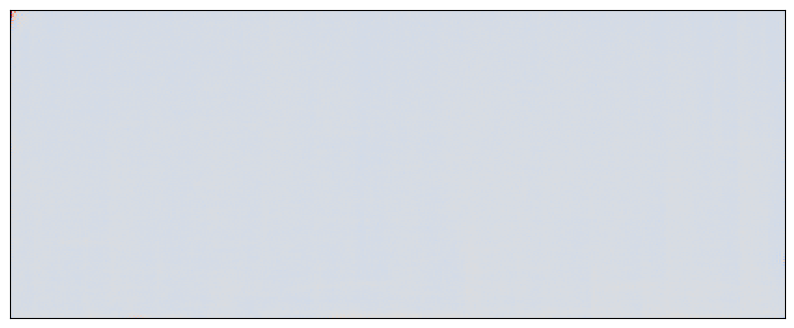

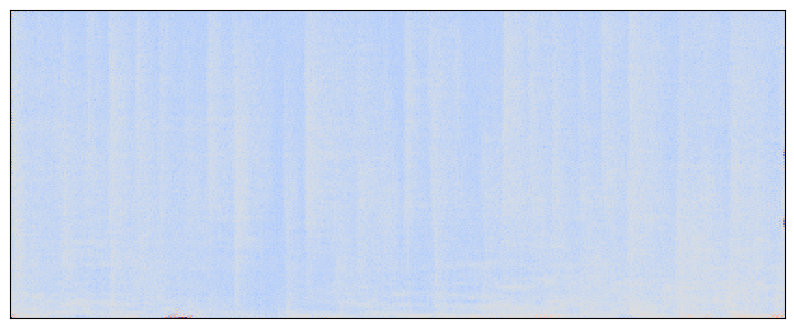

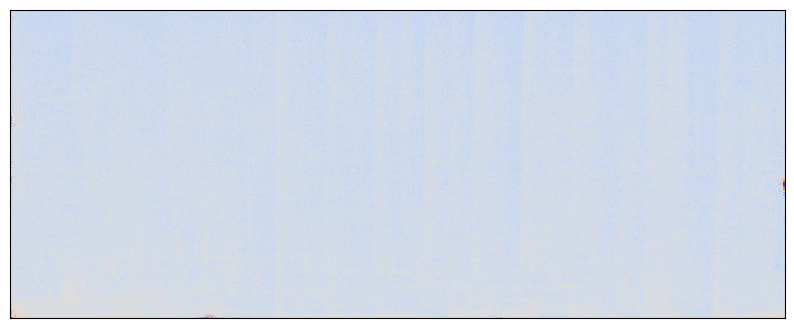

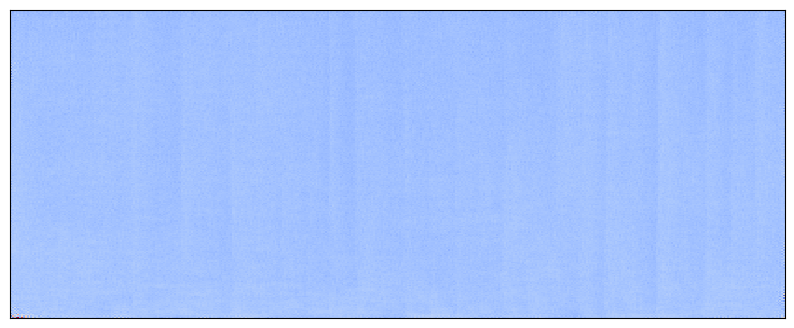

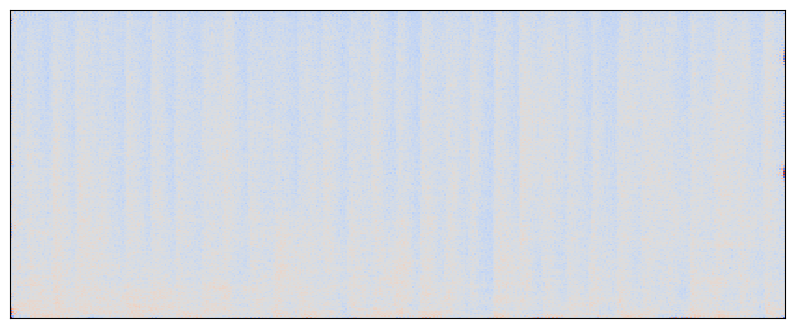

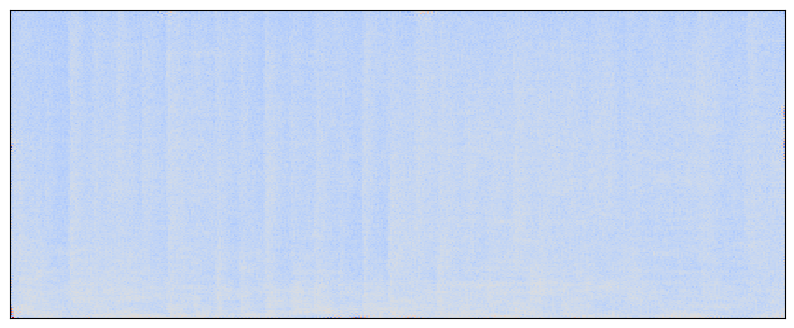

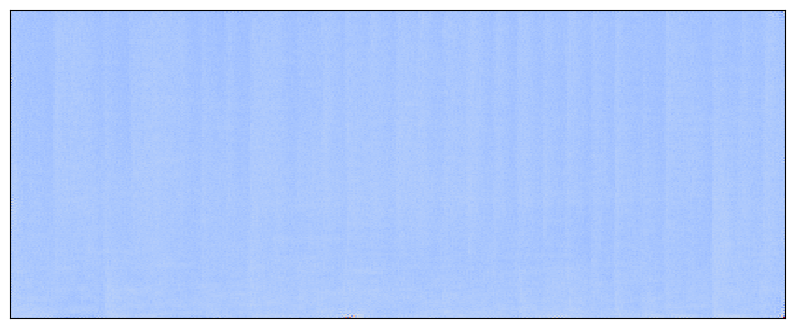

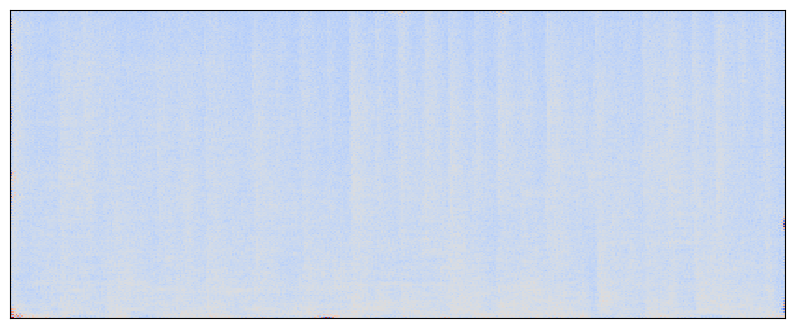

In [13]:
bwd_pass(model, n_samples=8, file_name="test")
#x: ndarray = model.bwd_diffusion(n_samples=8)

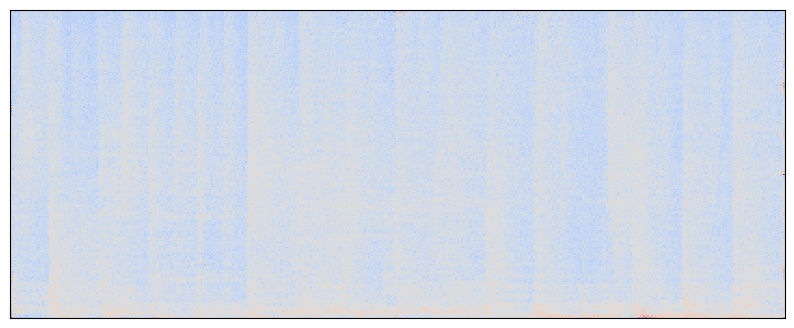

In [ ]:
#model.visualize_diffusion_steps(torch.tensor(file[:1]), 10)
x[2,0] = normalize(x[2,0], -1, 1)
visualize_spectogram(x[2,0])
save_spectogram(x[0,0], "Results/spec_dif_v3.jpg")

### Save Model Architecture

In [8]:
u_net.eval()
with torch.no_grad():
    u_net.eval()
with torch.no_grad():
    example_x = torch.randn(8, 1, file.shape[-2], file.shape[-1]).to(device)
    example_t = torch.randint(0, 500, (8,), dtype=torch.long).to(device)

    script_model = torch.jit.trace(u_net,(example_x, example_t), check_trace=False)
torch.jit.save(script_model, path_to_remote_path(f"{RESULT_PATH}/{model_name}.pt", remote_kernel))
#torchviz.make_dot(model(torch.randn(BATCH_SIZE, 1, file.shape[-2], file.shape[-1])), params=dict(model.named_parameters())).render(f"{RESULT_PATH}/{model_name}", format="png") #Not working
#logger.info(f"Saved model {path_to_remote_path(f"{RESULT_PATH}/{model_name}.pt", remote_kernel)}")